# Squat Sensor Experimentation

## Imports

In [37]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Configure matplotlib to show figures embedded in the notebook
%matplotlib inline

NUM_SENSORS = 5

## Utilities

In [45]:
# data: an N by num_sensors matrix, where N number of readings
# returns a list of length num_sensors, each is an array of shape (N,)
# h: smoothing filter
def preprocess_sensor_data(data, num_sensors, h):
    return np.apply_along_axis(lambda row: np.convolve(row, h, mode='valid'), axis=0, arr=data)

## Example: read in sensor data

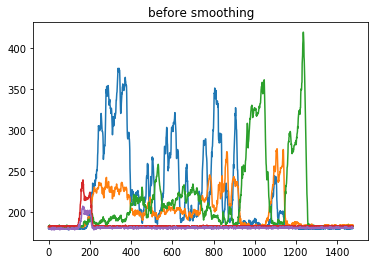

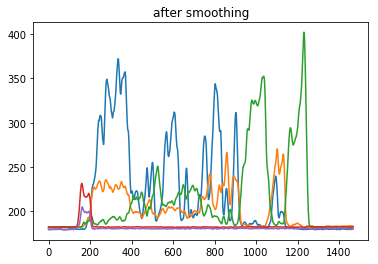

In [46]:
sensor_data = np.genfromtxt('input_heel_lift.csv', delimiter=',')
N, M = sensor_data.shape

sensor_data = sensor_data[0:-1]

plt.figure()
plt.title("before smoothing")
plt.plot(sensor_data)
plt.show()

h = np.ones(10)
h = h / np.sum(h)

sensor_data_smth = preprocess_sensor_data(sensor_data, NUM_SENSORS, h)

plt.figure()
plt.title("after smoothing")
plt.plot(sensor_data_smth)
plt.show()

## Read in actual sensor data to be used for training

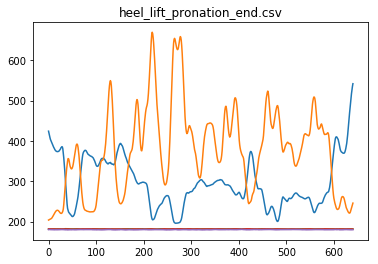

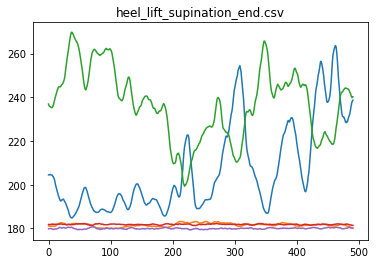

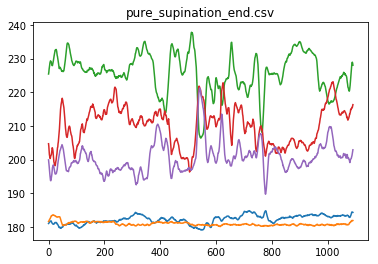

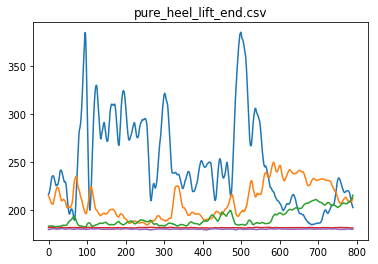

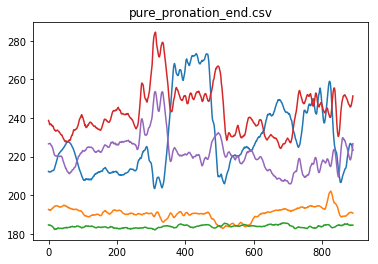

In [48]:
input_files = {'heel_lift_pronation_end.csv': (450, 1100), 
               'heel_lift_supination_end.csv': (200, 700), 
               'pure_supination_end.csv': (300, 1400),
               'pure_heel_lift_end.csv': (300, 1100),
               'pure_pronation_end.csv': (200, 1100)}

sensor_data_denoised = {}

for fn in input_files.keys():
    sensor_data = np.genfromtxt(fn, delimiter=',')
    sensor_data = sensor_data[input_files[fn][0]:input_files[fn][1]]
    sensor_data_smth = preprocess_sensor_data(sensor_data, NUM_SENSORS, h)
    sensor_data_denoised[fn] = sensor_data_smth
    plt.figure()
    plt.title(fn)
    plt.plot(sensor_data_smth)
    plt.show()

## Train a multiclass classifier

In [79]:
from sklearn.svm import LinearSVC

classes = {'heel_lift_pronation_end.csv': 0, 
           'heel_lift_supination_end.csv': 1, 
           'pure_supination_end.csv': 2,
           'pure_heel_lift_end.csv': 3,
           'pure_pronation_end.csv': 4}

# expects array-like data
def create_training_data(data, offset=5):
    N, M = data.shape
    idx = 0
    X_t = []
    while idx + offset <= N:
        X_t.append(data[idx:idx+offset].flatten(order='F'))
        idx += offset
    return np.array(X_t)

In [95]:
Xs = []
Ys = []
for key in sensor_data_denoised.keys():
    data = sensor_data_denoised[key]
    X_t = create_training_data(data)
    N_t, M_t = X_t.shape
    Xs.append(X_t)
    Ys.append([classes[key]] * N_t)

In [97]:
X = np.vstack(Xs)
Y = np.hstack(Ys)

print (X.shape)
print (Y.shape)

(780, 25)
(780,)


In [98]:
clf = LinearSVC().fit(X, Y)

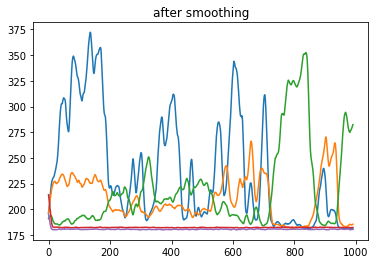

(198, 25)


In [101]:
test_sensor_data = np.genfromtxt('input_heel_lift.csv', delimiter=',')
N, M = test_sensor_data.shape

test_sensor_data = test_sensor_data[200:1200]

test_sensor_data_smth = preprocess_sensor_data(test_sensor_data, NUM_SENSORS, h)

plt.figure()
plt.title("after smoothing")
plt.plot(test_sensor_data_smth)
plt.show()

X_test = create_training_data(test_sensor_data_smth)

print(X_test.shape)

## Test Model

[4 4 3 3 3 3 3 3 0 3 3 3 3 3 0 0 0 0 0 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 3 3
 3 3 3 3 3 1 3 3 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 0 0 0 3 3 3 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 0 0 3 3 3 3
 3 3 3 3 1 1 1 1 1 1 1 1 1]


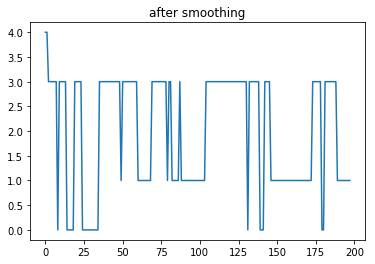

In [106]:
classes_inv = {0:'heel_lift_pronation_end.csv', 
               1:'heel_lift_supination_end.csv', 
               2:'pure_supination_end.csv',
               3:'pure_heel_lift_end.csv',
               4:'pure_pronation_end.csv'}

Z = clf.predict(X_test)

Z_str = [classes_inv[val] for val in Z]

print (Z)

plt.figure()
plt.title("after smoothing")
plt.plot(Z)
plt.show()